# Data generation
This notebook shows the capabilities of our decoder. Several signals are generated according to 4 different models for an input X constant, X random and X sinusoidal with additional noise.

## Librairies importation

In [78]:
print(f"Importing librairies ... ", end='')
import sys
sys.path.append(r"C:\Users\valentin\Documents\HMM")
import numpy as np
from myHmmPackage.cluster_decoder import ClusterDecoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
print('done')

print("Creating a directory for saving the figures ...", end="")
FIG_PATH = "data_generation_figures"
import os
if not os.path.exists(FIG_PATH):
    os.makedirs(FIG_PATH)
print(f"done - All figures will be downloaded under the directory '{FIG_PATH}/'")

Importing librairies ... done
Creating a directory for saving the figures ...done - All figures will be downloaded under the directory 'data_generation_figures/'


## Hyperparameters

In [94]:
### data ###
n_samples = 100 #n_trials
n_time_points = 100
n_regions = 2 #IC ou region ou electrod ou channels
n_label_features = 48 
n_clusters = 4 # n_clusters

## Data generation

In [95]:
def get_sinusoidal_X() :
    def a(t,r):
        idx = np.count_nonzero(transition <= t) - 1
        return a_list[idx,r]

    def omega(t,r):
        idx = np.count_nonzero(transition <= t) - 1
        return omega_list[idx,r]

    def f(s,t,r):
        return a(t,r)*np.cos(omega(t,r)*t) + sigma[s]*np.random.normal(loc=0, scale=sigma[s])


    return np.array([[[f(s,t,r) for r in range(n_regions)]
                            for t in range(n_time_points)]
                            for s in range(n_samples)],
                    dtype=float)

def get_random_X():
    return np.random.uniform(low=-10, high=10, size=(n_samples, n_time_points, n_regions))

def get_constant_X():
    return np.random.uniform(low=-10, high=10)*np.ones(shape=(n_samples, n_time_points, n_regions))

def get_mix_models(gamma,W):
    gamma = np.transpose(gamma,(1,0))
    W_temp = np.reshape(W, newshape=(n_regions, n_clusters, n_label_features))
    return np.sum(gamma @ W_temp, axis=1)
     
def get_y(X, W):
    y = X @ W
    y = np.reshape(y, newshape=(n_samples, n_time_points, n_label_features))
    return y

In [96]:
transition = np.random.randint(n_time_points,size=(n_clusters-1))
transition = np.concatenate(([0],np.sort(transition),[n_time_points]))
a_list = np.random.uniform(low=0,high=2*np.pi/n_time_points, size=(n_clusters,n_regions))
omega_list = np.random.uniform(low=0,high=2*np.pi/n_time_points, size=(n_clusters,n_regions))
sigma = np.random.uniform(low=0.001,high=0.1,size=n_samples)

data_type = 'sinusoidal' # valid input : constant, random, sinusoidal

if data_type == 'constant' :
    X_train = get_constant_X()
    X_test = get_constant_X()

elif data_type == 'random' :
    X_train = get_random_X()
    X_test = get_random_X()
    
elif data_type == 'sinusoidal' :
    X_train = get_sinusoidal_X()
    X_test = get_sinusoidal_X()

else :
    raise ValueError(f"Input received : '{data_type}. Valid input : 'constant', 'random', 'sinusoidal''")
    
W = np.random.randint(low=-10, high=10,size=(n_clusters, n_regions, n_label_features))

gamma = np.array([[0 if (transition[(j)] <= i) and (i < transition[(j+1)]) else 1 for i in range(n_time_points)] 
                for j in range(n_clusters)],dtype=int)
W_mix = get_mix_models(gamma, W)

y_train = get_y(X_train, W_mix)
y_test = get_y(X_test, W_mix)

## Plot

### Inputs X for a given region id_r

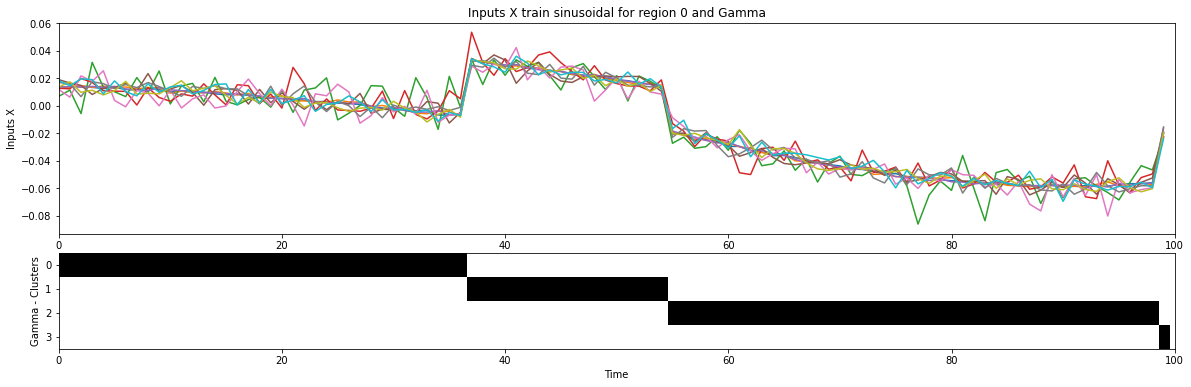

In [97]:
id_r = 0
fig = plt.figure(figsize=(20,6))

grid = plt.GridSpec(3, 1)
ax0 = fig.add_subplot(grid[:2, 0])
for id_s in range(10):
    ax0.plot(range(n_time_points), X_train[id_s,:,id_r])
plt.ylabel('Inputs X')
plt.xlim(0,n_time_points)
plt.title(f"Inputs X train {data_type} for region {id_r} and Gamma")


ax1 = fig.add_subplot(grid[2, 0])
ax1.imshow(gamma, cmap='gray', aspect='auto')
plt.ylabel("Gamma - Clusters")
plt.xlabel('Time')
plt.xlim(0,n_time_points)

plt.savefig(FIG_PATH+"/x_train_gamma.png")
plt.show()


### Models W

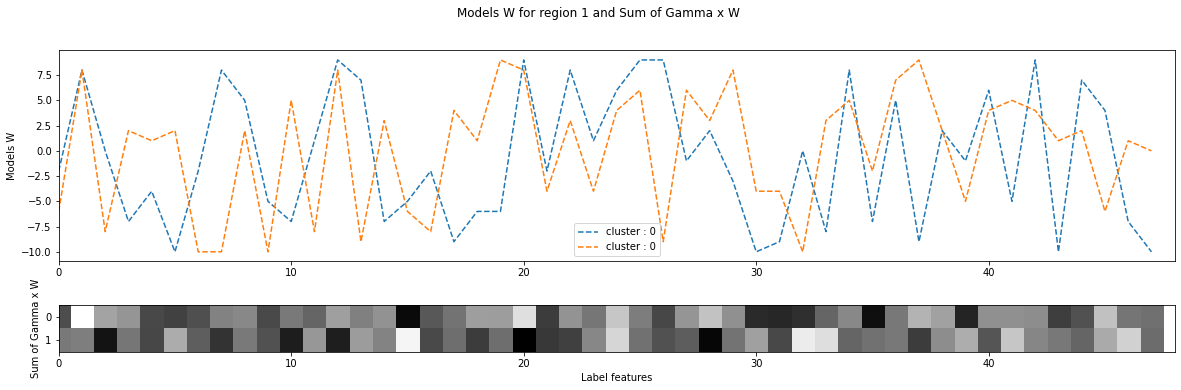

In [98]:
id_cluster = 0
fig = plt.figure(figsize=(20,6))
grid = plt.GridSpec(3, 1)

ax0 = fig.add_subplot(grid[:2, 0])
for id_r in range(n_regions):
    plt.plot(W[id_cluster,id_r,:].T, '--', label=f"cluster : {id_cluster}" )
plt.ylabel("Models W")
plt.xlim(0,n_label_features)
plt.legend()

ax1 = fig.add_subplot(grid[2, 0])
plt.imshow(W_mix,cmap='gray')
plt.ylabel("Sum of Gamma x W")
plt.xlim(0,n_label_features)

plt.xlabel("Label features")
plt.suptitle(f"Models W for region {id_r} and Sum of Gamma x W")

plt.savefig(FIG_PATH+"/models_W_;_sum_gamma_W.png")
plt.show()

## Training

In [104]:
print(f"Starting cluster decoder ... ")
clf = ClusterDecoder(n_clusters=n_clusters, method='sequential', max_iter=1e3)
clf.fit(X_train,y_train) # renvoie gamma et W
print('done\n')

Starting cluster decoder ... 


100%|██████████| 999/999 [00:10<00:00, 92.95it/s] 

done



## Results

### Gamma

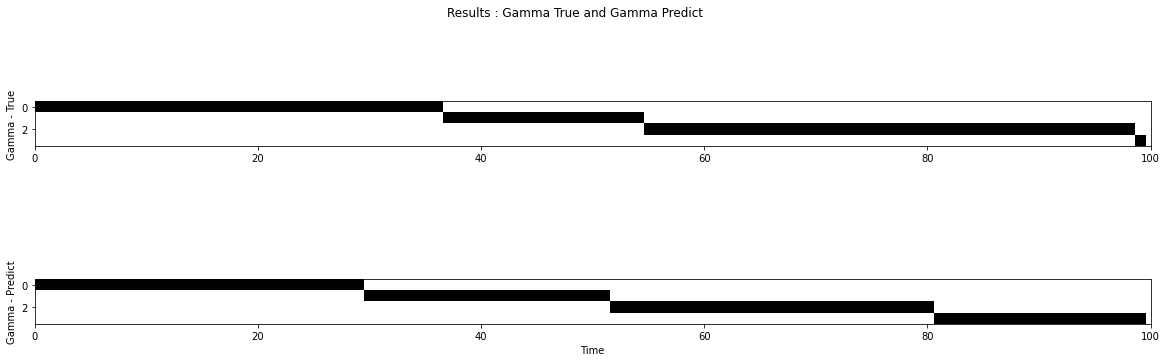

In [100]:
fig = plt.figure(figsize=(20,6))
grid = plt.GridSpec(2, 1)

ax0 = fig.add_subplot(grid[:1, 0])
plt.imshow(gamma,cmap='gray')
plt.ylabel("Gamma - True")
plt.xlim(0,n_time_points)

ax1 = fig.add_subplot(grid[1:, 0])
plt.imshow(1-clf.gamma_.T,cmap='gray')
plt.ylabel("Gamma - Predict")
plt.xlim(0,n_time_points)


plt.xlabel("Time")
plt.suptitle(f"Results : Gamma True and Gamma Predict")

plt.savefig(FIG_PATH+"/gamma_true_gamma_predict.png")
plt.show()

### Models W

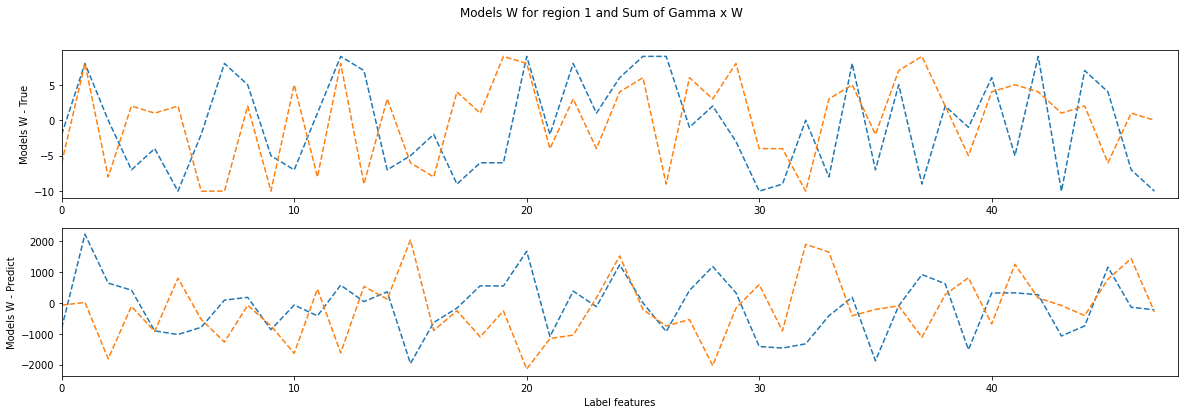

In [101]:
id_cluster = 0
fig = plt.figure(figsize=(20,6))
grid = plt.GridSpec(2, 1)

ax0 = fig.add_subplot(grid[:1, 0])
for id_r in range(n_regions):
    plt.plot(W[id_cluster,id_r,:].T, '--', label=f"cluster : {id_cluster}" )
plt.ylabel("Models W - True")
plt.xlim(0,n_label_features)

ax1 = fig.add_subplot(grid[1:, 0])
for id_r in range(n_regions):
    plt.plot(clf.decoding_mats_[id_cluster,id_r,:].T, '--', label=f"cluster : {id_cluster}" )
plt.ylabel("Models W - Predict")
plt.xlim(0,n_label_features)


plt.xlabel("Label features")
plt.suptitle(f"Models W for region {id_r} and Sum of Gamma x W")

plt.savefig(FIG_PATH+"/results_W_true;W_predict.png")
plt.show()

## Test

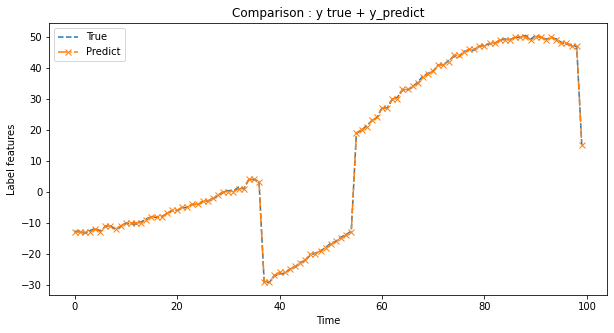

In [102]:
id_sample = 0
id_feat = 0
plt.figure(figsize=(10,5))
plt.plot(y_train[id_sample,:,id_feat].T, '--', label="True")
plt.plot(clf.predict(X_train)[id_sample,:,id_feat].T, '-.x', label="Predict")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Label features")
plt.title("Comparison : y true + y_predict")
plt.savefig(FIG_PATH+"/results_y_train_;_y_predict")
plt.show()

In [103]:
y_true = y_train.flatten()
y_predict = clf.predict(X_train).flatten()
print(f"r2_score : {r2_score(y_true, y_predict)}")
print(f"mean_squared_error : {mean_squared_error(y_true, y_predict)}")    
print(f"mean_absolute_percentage_error : {mean_absolute_percentage_error(y_true, y_predict)}")

r2_score : 0.9999442907458996
mean_squared_error : 0.08359149946192397
mean_absolute_percentage_error : 0.04453470159790452
